Binary 6/6 (MT + NU) A)

mRNA localization using binary classification (mitochondria/nucleus) (part 1): basic model with: <br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 2: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance, i.e. PredictionValuesChange) <br>
c) Method 3: with feature importance-based feature selection (feature importance type: SHAP values)

In [32]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report

In [3]:
#data initialization

#Mitochondria (label = 2)
MT_train = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_train_CSV.csv")
MT_test = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_test_CSV.csv")

#Nucleus (label = 3)
NU_train = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_train_CSV.csv")
NU_test = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_test_CSV.csv")


print("MT TRAIN, TEST SHAPE:", MT_train.shape, ",", MT_test.shape)
print("NU TRAIN, TEST SHAPE:", NU_train.shape, ",", NU_test.shape)

MT TRAIN, TEST SHAPE: (280, 1026) , (70, 1026)
NU TRAIN, TEST SHAPE: (640, 1026) , (160, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:

#Group 6: MT + NU

frames_MN_tra =[MT_train, NU_train]
frames_MN_tes =[MT_test, NU_test]

MT_NU_train = pd.concat(frames_MN_tra)
MT_NU_test = pd.concat(frames_MN_tes)

In [6]:

print("\nMT + NU TRAIN, TEST SHAPE:", MT_NU_train.shape, ",", MT_NU_test.shape)


MT + NU TRAIN, TEST SHAPE: (920, 1026) , (230, 1026)


In [7]:
MT_NU_test.head(73)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_18808#856050|2|testing,2,0.001747,0.001747,0.005240,0.005240,0.001747,0.000873,0.002620,0.001747,...,0.000873,0.001747,0.001747,0.001747,0.001747,0.001747,0.001747,0.000873,0.001747,0.003493
1,mRNALoc_18516#852314|2|testing,2,0.010536,0.004390,0.004390,0.006146,0.003512,0.001756,0.000878,0.001756,...,0.000000,0.002634,0.003512,0.000878,0.003512,0.000878,0.001756,0.002634,0.004390,0.000000
2,mRNALoc_18612#853304|2|testing,2,0.004390,0.001756,0.002634,0.001756,0.003512,0.001756,0.000000,0.001756,...,0.000000,0.000000,0.002634,0.001756,0.000878,0.000000,0.005268,0.000878,0.002634,0.009658
3,mRNALoc_18679#854170|2|testing,2,0.001765,0.003530,0.002648,0.000000,0.001765,0.000883,0.000000,0.002648,...,0.000883,0.000000,0.000000,0.000883,0.001765,0.001765,0.002648,0.002648,0.000883,0.000883
4,mRNALoc_18546#852637|2|testing,2,0.000000,0.000887,0.001775,0.000000,0.001775,0.002662,0.000887,0.000000,...,0.002662,0.000887,0.002662,0.000887,0.004437,0.000887,0.002662,0.004437,0.002662,0.002662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,mRNALoc_18370#850602|2|testing,2,0.007919,0.003394,0.007919,0.002262,0.007919,0.003394,0.000000,0.004525,...,0.001131,0.001131,0.000000,0.000000,0.005656,0.001131,0.002262,0.002262,0.001131,0.002262
69,mRNALoc_18476#851819|2|testing,2,0.010181,0.003394,0.005656,0.001131,0.002262,0.003394,0.000000,0.001131,...,0.001131,0.004525,0.003394,0.002262,0.001131,0.001131,0.001131,0.001131,0.003394,0.003394
0,mRNALoc_4836#21374|3|testing,3,0.001632,0.002176,0.001632,0.002176,0.001632,0.001088,0.000544,0.001088,...,0.000000,0.004353,0.000544,0.000544,0.001632,0.002176,0.003264,0.002720,0.002720,0.004897
1,mRNALoc_7063#26002|3|testing,3,0.002176,0.001088,0.003264,0.000544,0.001088,0.000544,0.000000,0.001088,...,0.000544,0.001632,0.001088,0.002176,0.001088,0.000000,0.001088,0.001088,0.001088,0.000544


In [8]:
#FOR MT+NU
noname_MN_train = MT_NU_train.drop("#", axis="columns")
noname_MN_test = MT_NU_test.drop("#", axis="columns")


MT_NU_X_train = noname_MN_train.drop("label", axis="columns")
MT_NU_y_train = noname_MN_train["label"]

MT_NU_X_test = noname_MN_test.drop("label", axis="columns")
MT_NU_y_test = noname_MN_test["label"]

print("MT + NU X train:", MT_NU_X_train.shape)
print("MT + NU y train:", MT_NU_y_train.shape)
print("MT + NU X test:", MT_NU_X_test.shape)
print("MT + NU y test:", MT_NU_y_test.shape)

MT + NU X train: (920, 1024)
MT + NU y train: (920,)
MT + NU X test: (230, 1024)
MT + NU y test: (230,)


In [9]:
# Create data pools for feature importance/selection for MT + NU

MN_feature_names = list(MT_NU_X_train.columns)
print("Number of features:", len(MN_feature_names))

MN_train_pool = Pool(MT_NU_X_train, MT_NU_y_train, feature_names=MN_feature_names)

MN_test_pool = Pool(MT_NU_X_test, MT_NU_y_test)

print("*Mitochondria, Nucleus Pools created")

Number of features: 1024
*Mitochondria, Nucleus Pools created


    Method 1: Initial classification (without feature importance, selection or auto_class_weights)

In [10]:
MN_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [11]:
#Fit model to MN data

MN_binary_model.fit(MN_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6453486	total: 217ms	remaining: 3m 36s
1:	learn: 0.5967207	total: 363ms	remaining: 3m 1s
2:	learn: 0.5594406	total: 491ms	remaining: 2m 43s
3:	learn: 0.5220241	total: 623ms	remaining: 2m 35s
4:	learn: 0.4861558	total: 758ms	remaining: 2m 30s
5:	learn: 0.4591905	total: 885ms	remaining: 2m 26s
6:	learn: 0.4324965	total: 1.02s	remaining: 2m 24s
7:	learn: 0.4082558	total: 1.14s	remaining: 2m 21s
8:	learn: 0.3840052	total: 1.27s	remaining: 2m 20s
9:	learn: 0.3617618	total: 1.4s	remaining: 2m 18s
10:	learn: 0.3416231	total: 1.51s	remaining: 2m 16s
11:	learn: 0.3234066	total: 1.67s	remaining: 2m 17s
12:	learn: 0.3071336	total: 1.8s	remaining: 2m 16s
13:	learn: 0.2922344	total: 1.92s	remaining: 2m 15s
14:	learn: 0.2772289	total: 2.05s	remaining: 2m 14s
15:	learn: 0.2645473	total: 2.17s	remaining: 2m 13s
16:	learn: 0.2521766	total: 2.3s	remaining: 2m 13s
17:	learn: 0.2410430	total: 2.52s	remaining: 2m 17s
18:	learn: 0.2314290	total: 2.65s	remaining: 2m 

In [12]:
#Check parameters used in this model fit

MN_bin_params = MN_binary_model.get_all_params()
print("Basic model parameters:", MN_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07879099994897842,

In [13]:
#Prediction using X_test
MN_y_pred = MN_binary_model.predict(MT_NU_X_test)

#Predication probability

MN_y_prob = MN_binary_model.predict_proba(MT_NU_X_test)

In [14]:
# Calculate F1 score and get classification report

print("Model 1: Basic model - Mitochondria & nucleus")

MN_cr = classification_report(MT_NU_y_test, MN_y_pred, digits=3)
print(MN_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_y_pred))

MN_f1 = f1_score(MT_NU_y_test, MN_y_pred, average='macro')
print(f"\nF1 Score: {MN_f1}")
# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_y_prob))

Model 1: Basic model - Mitochondria & nucleus
              precision    recall  f1-score   support

           2      0.707     1.000     0.828        70
           3      1.000     0.819     0.900       160

    accuracy                          0.874       230
   macro avg      0.854     0.909     0.864       230
weighted avg      0.911     0.874     0.878       230

Accuracy score:  0.8739130434782608

F1 Score: 0.8643730047377944


In [15]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_y_pred.shape)

MN_y_pred_fl = MN_y_pred
print("flattened prediction values shape:", MN_y_pred_fl.ravel().shape, "\n")

MN_cMatrix = confusion_matrix(MT_NU_y_test, MN_y_pred_fl)
print(MN_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 29 131]]


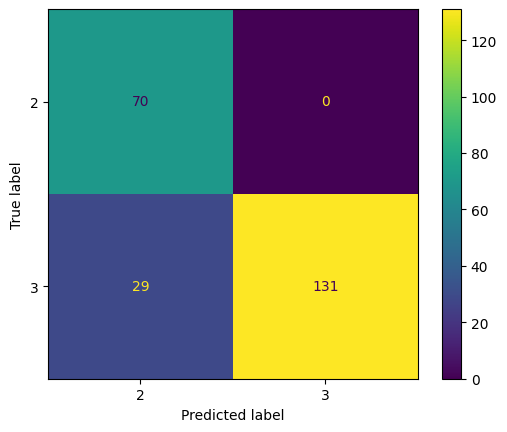

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_cMatrix, display_labels=MN_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [17]:
#Feature importances for CM pair

MN_feat_importances = MN_binary_model.get_feature_importance(prettified=True)
MN_feat_importances.head(100)

,Feature Id,Importances
0,CAGCT,6.920010
1,CCCCC,5.294068
2,TATCG,5.011204
3,CGGTA,3.013808
4,AGCAG,2.661691
...,...,...
95,CGGTC,0.175875
96,CGTGG,0.174687
97,AAGAT,0.174337
98,TGTCG,0.173563


In [18]:
# Show only feature importances above 0.1

threshold_chosen_features = MN_feat_importances[MN_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        CAGCT     6.920010
1        CCCCC     5.294068
2        TATCG     5.011204
3        CGGTA     3.013808
4        AGCAG     2.661691
..         ...          ...
144      AGTCT     0.104196
145      ATGCA     0.101871
146      GTAAT     0.101446
147      GCATC     0.101190
148      CGTTT     0.100910

[149 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 149


In [19]:
print("Sum of total feature importances: ", sum(MN_feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.99999999999989
Sum of feature importances >=0.1:  84.79273045320687


In [20]:
# Select features with importance values above 0.1

MN_selected_feat = MN_feat_importances[:num_chosen_features]['Feature Id'].tolist()

# print(MN_selected_feat)

In [21]:
MT_NU_X_train.shape

(920, 1024)

In [22]:
# See original training set

MT_NU_X_train.head(283)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435
1,0.006502,0.002956,0.001970,0.003941,0.004138,0.001576,0.001379,0.001379,0.002562,0.001970,...,0.000591,0.001970,0.001576,0.000394,0.001773,0.001773,0.004729,0.003350,0.002365,0.014778
2,0.010090,0.001682,0.003784,0.002943,0.001892,0.001892,0.000420,0.001472,0.003153,0.002523,...,0.000210,0.002312,0.000841,0.001472,0.001892,0.001682,0.001051,0.002102,0.000841,0.003153
3,0.002139,0.001528,0.002139,0.003362,0.001528,0.001222,0.000917,0.001528,0.003056,0.001528,...,0.000917,0.001222,0.003667,0.002751,0.002139,0.002751,0.000306,0.002751,0.002751,0.002445
4,0.001737,0.000000,0.000579,0.002895,0.000579,0.000000,0.000000,0.002895,0.002316,0.001158,...,0.002895,0.005790,0.002316,0.001737,0.002895,0.004632,0.002316,0.005211,0.002895,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.004355,0.000871,0.003484,0.005226,0.003484,0.000000,0.000000,0.000871,0.006098,0.003484,...,0.001742,0.004355,0.003484,0.002613,0.000000,0.002613,0.002613,0.006098,0.003484,0.007840
279,0.011354,0.001747,0.004367,0.006114,0.003493,0.000873,0.000873,0.001747,0.005240,0.002620,...,0.000000,0.000873,0.003493,0.000873,0.000873,0.000873,0.001747,0.000873,0.001747,0.003493
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835
1,0.000000,0.000000,0.000000,0.001450,0.000000,0.000725,0.000000,0.000000,0.000725,0.000000,...,0.000000,0.000725,0.003626,0.001450,0.001450,0.000725,0.000725,0.000725,0.001450,0.000000


In [23]:
#Create training set with selected features 

MN_X_train_selected = MT_NU_X_train[MN_selected_feat]
MN_X_train_selected.head()

,CAGCT,CCCCC,TATCG,CGGTA,AGCAG,TCCAA,CAGCA,TCAGC,ACGTT,CGTTA,...,GAGGC,CTGAC,ACTAA,GCGGG,ACCAG,AGTCT,ATGCA,GTAAT,GCATC,CGTTT
0,0.001076,0.00000,0.000717,0.000359,0.001435,0.000897,0.002152,0.000897,0.000717,0.000717,...,0.000717,0.000897,0.001435,0.000179,0.000359,0.000359,0.000897,0.000179,0.001076,0.000717
1,0.000788,0.00197,0.000394,0.000788,0.003350,0.002759,0.003153,0.000788,0.000788,0.000985,...,0.000591,0.000788,0.000788,0.000197,0.000985,0.001182,0.001182,0.000591,0.000591,0.000591
2,0.001051,0.00021,0.001051,0.000000,0.002312,0.002523,0.001472,0.001472,0.001261,0.000420,...,0.002102,0.002102,0.000841,0.000210,0.001261,0.000631,0.001261,0.000631,0.000631,0.000631
3,0.000306,0.00000,0.000611,0.000917,0.000917,0.001222,0.000611,0.000306,0.001528,0.000917,...,0.000611,0.001528,0.001834,0.000000,0.000917,0.000917,0.000611,0.000917,0.000917,0.000611
4,0.001737,0.00000,0.000579,0.002316,0.000579,0.005211,0.000579,0.000579,0.002316,0.001158,...,0.000000,0.000579,0.001737,0.000000,0.000000,0.000579,0.000579,0.000579,0.000000,0.001737


In [24]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(MN_X_train_selected.columns) == MN_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [25]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", MN_X_train_selected.shape)
print("Shape of y_train (number of labels):", MT_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (920, 149)
Shape of y_train (number of labels): (920,)


In [26]:
# Create pool object for selected feature data
print("Original number of features:", len(MN_feature_names), "\n Number of selected features:", len(MN_selected_feat))

MN_selected_train_pool = Pool(MN_X_train_selected, MT_NU_y_train, feature_names=MN_selected_feat)

Original number of features: 1024 
 Number of selected features: 149


In [27]:
#Create new model for data with selected features
MN_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

MN_FIFS_model.fit(MN_selected_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6450339	total: 28.7ms	remaining: 28.7s
1:	learn: 0.5981686	total: 50.5ms	remaining: 25.2s
2:	learn: 0.5544198	total: 68.5ms	remaining: 22.8s
3:	learn: 0.5176368	total: 148ms	remaining: 36.8s
4:	learn: 0.4837225	total: 197ms	remaining: 39.2s
5:	learn: 0.4541652	total: 217ms	remaining: 35.9s
6:	learn: 0.4249312	total: 236ms	remaining: 33.5s
7:	learn: 0.3991125	total: 271ms	remaining: 33.6s
8:	learn: 0.3763180	total: 340ms	remaining: 37.4s
9:	learn: 0.3549683	total: 366ms	remaining: 36.3s
10:	learn: 0.3358924	total: 389ms	remaining: 35s
11:	learn: 0.3170123	total: 410ms	remaining: 33.7s
12:	learn: 0.3000888	total: 429ms	remaining: 32.6s
13:	learn: 0.2838369	total: 453ms	remaining: 31.9s
14:	learn: 0.2702238	total: 473ms	remaining: 31.1s
15:	learn: 0.2573720	total: 496ms	remaining: 30.5s
16:	learn: 0.2447334	total: 521ms	remaining: 30.2s
17:	learn: 0.2330441	total: 543ms	remaining: 29.6s
18:	learn: 0.2215785	total: 563ms	remaining: 29.1s
19:	learn:

In [28]:
#Prediction using X_test only for selected features data
MN_FIFS_y_pred = MN_FIFS_model.predict(MT_NU_X_test)

#Predication probability for selected features data

MN_FIFS_y_prob = MN_FIFS_model.predict_proba(MT_NU_X_test)

In [29]:
# Calculate F1 score and get classification report

print("Model 2: Feature selection (PredictionValuesChange) - Mitochondria & nucleus")

print("Number of chosen features:", num_chosen_features, "\n")

MN_FIFS_cr = classification_report(MT_NU_y_test, MN_FIFS_y_pred, digits=3)
print(MN_FIFS_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_FIFS_y_pred))

MN_FIFS_f1 = f1_score(MT_NU_y_test, MN_FIFS_y_pred, average='macro')
print(f"\nF1 Score: {MN_FIFS_f1}")

# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_FIFS_y_prob))

Model 2: Feature selection (PredictionValuesChange) - Mitochondria & nucleus
Number of chosen features: 149 

              precision    recall  f1-score   support

           2      0.722     1.000     0.838        70
           3      1.000     0.831     0.908       160

    accuracy                          0.883       230
   macro avg      0.861     0.916     0.873       230
weighted avg      0.915     0.883     0.887       230

Accuracy score:  0.8826086956521739

F1 Score: 0.8730865913224746


In [30]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_FIFS_y_pred.shape)

MN_FIFS_y_pred_fl = MN_FIFS_y_pred
print("flattened prediction values shape:", MN_FIFS_y_pred_fl.ravel().shape, "\n")

MN_FIFS_cMatrix = confusion_matrix(MT_NU_y_test, MN_FIFS_y_pred_fl)
print(MN_FIFS_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 27 133]]


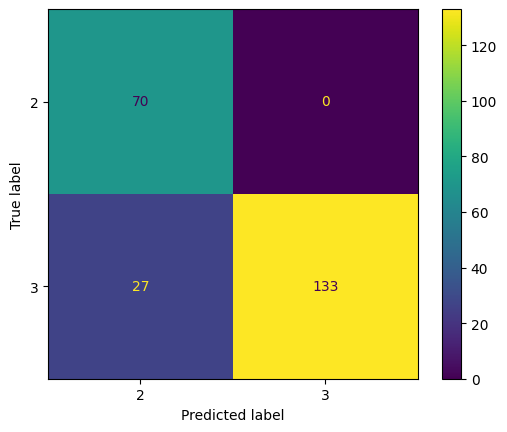

In [31]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_FIFS_cMatrix, display_labels=MN_FIFS_model.classes_)
disp.plot()
plt.show()

**************

    Method 3: Modelling using feature selection based on feature importance values (SHAP Values)

In [33]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(MN_binary_model)

In [34]:
#SHAP values for X_train
MN_shap_values = explainer.shap_values(MT_NU_X_train)

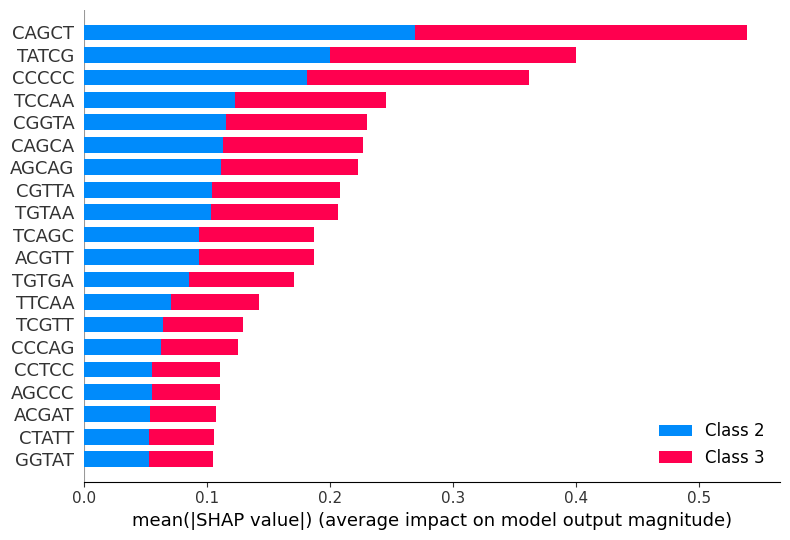

In [36]:
shap.summary_plot(MN_shap_values, MT_NU_X_train, plot_size=0.2, class_names=["Class 2", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


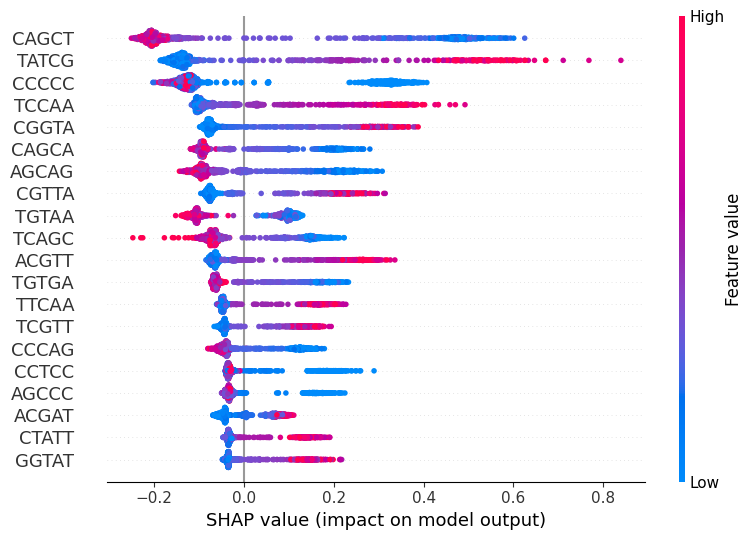

In [37]:
# Summary shap bar plot of Cytoplasm class (class 0)
shap.summary_plot(MN_shap_values[0], MT_NU_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


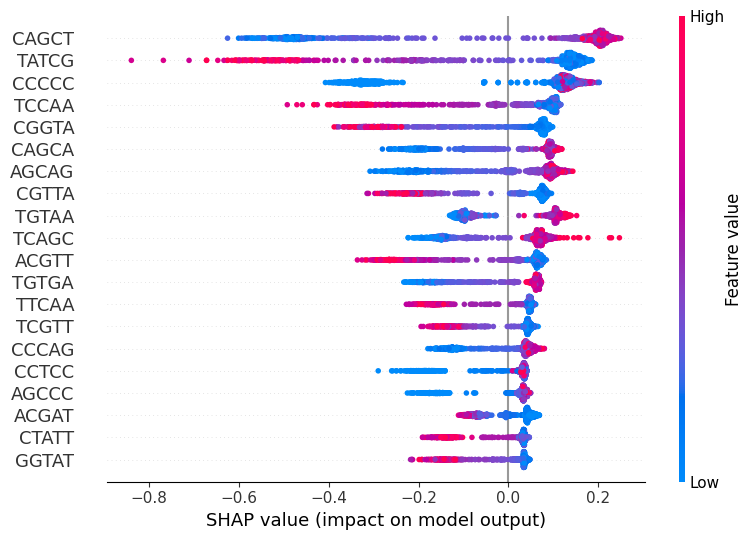

In [38]:
# Summary shap bar plot of Endoplasmic reticuum class (class 1)
shap.summary_plot(MN_shap_values[1], MT_NU_X_train, plot_size=0.2)

In [40]:
#Put values one one class into dataframe to use as reference values for FS
shap_df = pd.DataFrame(MN_shap_values[0], columns=MT_NU_X_train.columns)


In [41]:
# Calculate feature importance by only taking the values which 
MN_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [42]:
MN_shap_FI.head()

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,CAGCT,0.434662
1,TATCG,0.359942
2,CCCCC,0.310677
3,TTTTT,0.288863
4,CGGTA,0.238025


In [43]:
# shap.summary_plot(MN_shap_values[0], MT_NU_X_train, show=False, max_display=30, plot_size=0.2)

In [44]:
#Classifier results with MN_feature_importance

In [45]:
from numpy import nansum
print("Sum of all shap feature importance values:", nansum(MN_shap_FI["Importances"]))

Sum of all shap feature importance values: 10.119804222394428


In [46]:
# Show only feature importances above 0.017 (0.05/3 = 0.017)

MN_SHAP_thres_chosen = MN_shap_FI[MN_shap_FI['Importances'] >= 0.017]
MN_shap_num_chosen = len(MN_SHAP_thres_chosen)

print(MN_SHAP_thres_chosen)

print("\nAmount of features with importance above 0.017 (selected features):", MN_shap_num_chosen)

    Feature Id  Importances
0        CAGCT     0.434662
1        TATCG     0.359942
2        CCCCC     0.310677
3        TTTTT     0.288863
4        CGGTA     0.238025
..         ...          ...
109      TGCTA     0.018438
110      ATTGA     0.018246
111      AACGT     0.017615
112      TTACC     0.017110
113      CAGAT     0.017034

[114 rows x 2 columns]

Amount of features with importance above 0.017 (selected features): 114


In [48]:
print("Sum of total feature importances: ", sum(MN_shap_FI.Importances))
print("Sum of feature importances >=0.017: ", sum(MN_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >=0.017:  7.69721724264371


In [49]:
# Select features with importance values above 0.1

MN_shap_selected_feat = MN_shap_FI[:MN_shap_num_chosen]['Feature Id'].tolist()

# print(MN_shap_selected_feat)

In [50]:
MT_NU_X_train.shape

(920, 1024)

In [51]:
# See original training set

MT_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435
1,0.006502,0.002956,0.001970,0.003941,0.004138,0.001576,0.001379,0.001379,0.002562,0.001970,...,0.000591,0.001970,0.001576,0.000394,0.001773,0.001773,0.004729,0.003350,0.002365,0.014778
2,0.010090,0.001682,0.003784,0.002943,0.001892,0.001892,0.000420,0.001472,0.003153,0.002523,...,0.000210,0.002312,0.000841,0.001472,0.001892,0.001682,0.001051,0.002102,0.000841,0.003153
3,0.002139,0.001528,0.002139,0.003362,0.001528,0.001222,0.000917,0.001528,0.003056,0.001528,...,0.000917,0.001222,0.003667,0.002751,0.002139,0.002751,0.000306,0.002751,0.002751,0.002445
4,0.001737,0.000000,0.000579,0.002895,0.000579,0.000000,0.000000,0.002895,0.002316,0.001158,...,0.002895,0.005790,0.002316,0.001737,0.002895,0.004632,0.002316,0.005211,0.002895,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,0.006428,0.004326,0.004203,0.005562,0.005686,0.002349,0.000618,0.002101,0.003832,0.003214,...,0.000247,0.001607,0.001360,0.000742,0.000865,0.002225,0.001731,0.001112,0.001112,0.000618
542,0.004331,0.002475,0.002598,0.002970,0.002103,0.000619,0.000000,0.001732,0.002351,0.001237,...,0.000247,0.001361,0.002598,0.001980,0.001485,0.001609,0.002846,0.001361,0.002351,0.003464
543,0.005940,0.001237,0.002722,0.002970,0.001361,0.001732,0.000124,0.002104,0.002599,0.001980,...,0.000247,0.002475,0.000990,0.001361,0.002351,0.002351,0.001856,0.001609,0.002970,0.003217
544,0.002353,0.001734,0.001981,0.002353,0.001734,0.001362,0.000619,0.001362,0.003096,0.001238,...,0.000371,0.001238,0.001238,0.001114,0.001610,0.001610,0.001486,0.001486,0.001362,0.000743


In [52]:
#Create training set with selected features 

MN_X_train_shap_selected = MT_NU_X_train[MN_shap_selected_feat]
MN_X_train_shap_selected.head()

,CAGCT,TATCG,CCCCC,TTTTT,CGGTA,TCCAA,ACGTT,CGTTA,AGCAG,CCTCC,...,AACGA,CGATG,ATGTA,CTGTG,GTCGA,TGCTA,ATTGA,AACGT,TTACC,CAGAT
0,0.001076,0.000717,0.00000,0.001435,0.000359,0.000897,0.000717,0.000717,0.001435,0.000000,...,0.001973,0.001614,0.000717,0.001076,0.001076,0.002511,0.001973,0.001435,0.001435,0.002690
1,0.000788,0.000394,0.00197,0.014778,0.000788,0.002759,0.000788,0.000985,0.003350,0.001576,...,0.001576,0.000000,0.001576,0.001773,0.000000,0.000394,0.001773,0.000394,0.000197,0.000788
2,0.001051,0.001051,0.00021,0.003153,0.000000,0.002523,0.001261,0.000420,0.002312,0.001051,...,0.000000,0.000210,0.000841,0.002312,0.000000,0.001261,0.000631,0.000210,0.000420,0.000631
3,0.000306,0.000611,0.00000,0.002445,0.000917,0.001222,0.001528,0.000917,0.000917,0.001528,...,0.001528,0.000306,0.000306,0.000611,0.000611,0.001222,0.001834,0.000917,0.001222,0.000611
4,0.001737,0.000579,0.00000,0.000000,0.002316,0.005211,0.002316,0.001158,0.000579,0.001158,...,0.000000,0.000579,0.000579,0.000000,0.001158,0.001158,0.002316,0.000579,0.000579,0.000000


In [53]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(MN_X_train_shap_selected.columns) == MN_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [54]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", MN_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", MT_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (920, 114)
Shape of y_train (number of labels): (920,)


In [55]:
# Create pool object for selected feature data
print("Original number of features:", len(MN_feature_names), "\n Number of selected features:", len(MN_shap_selected_feat))

MN_shap_selected_train_pool = Pool(MN_X_train_shap_selected, MT_NU_y_train, feature_names=MN_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 114


In [56]:
#Create new model for data with selected features
MN_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

MN_FIFS_shap_model.fit(MN_shap_selected_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6420817	total: 28.2ms	remaining: 28.2s
1:	learn: 0.5937956	total: 56.2ms	remaining: 28.1s
2:	learn: 0.5511034	total: 78.1ms	remaining: 26s
3:	learn: 0.5126054	total: 97.2ms	remaining: 24.2s
4:	learn: 0.4797845	total: 115ms	remaining: 22.9s
5:	learn: 0.4481855	total: 133ms	remaining: 22s
6:	learn: 0.4200895	total: 150ms	remaining: 21.3s
7:	learn: 0.3949892	total: 164ms	remaining: 20.4s
8:	learn: 0.3712736	total: 180ms	remaining: 19.8s
9:	learn: 0.3496864	total: 196ms	remaining: 19.4s
10:	learn: 0.3306582	total: 213ms	remaining: 19.1s
11:	learn: 0.3119342	total: 231ms	remaining: 19.1s
12:	learn: 0.2940431	total: 245ms	remaining: 18.6s
13:	learn: 0.2794001	total: 262ms	remaining: 18.5s
14:	learn: 0.2644901	total: 279ms	remaining: 18.3s
15:	learn: 0.2519008	total: 297ms	remaining: 18.2s
16:	learn: 0.2395318	total: 313ms	remaining: 18.1s
17:	learn: 0.2277215	total: 329ms	remaining: 17.9s
18:	learn: 0.2171186	total: 343ms	remaining: 17.7s
19:	learn: 

In [57]:
#Check parameters used in this model fit

MN_FIFS_shap_params = MN_FIFS_shap_model.get_all_params()
print("Basic model parameters:", MN_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07879099994897842,

In [58]:
#Prediction using X_test only for selected features data
MN_FIFS_shap_y_pred = MN_FIFS_shap_model.predict(MT_NU_X_test)

#Predication probability for selected features data

MN_FIFS_shap_y_prob = MN_FIFS_shap_model.predict_proba(MT_NU_X_test)

In [59]:
# Calculate F1 score and get classification report

print("Model 3: Feature selection (SHAP) - Mitochondria & nucleus")

print("Number of chosen features:", len(MN_shap_selected_feat), "\n")

MN_FIFS_shap_cr = classification_report(MT_NU_y_test, MN_FIFS_shap_y_pred, digits=3)
print(MN_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_FIFS_shap_y_pred))

MN_FIFS_shap_f1 = f1_score(MT_NU_y_test, MN_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {MN_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_FIFS_shap_y_prob))

Model 3: Feature selection (SHAP) - Mitochondria & nucleus
Number of chosen features: 114 

              precision    recall  f1-score   support

           2      0.722     1.000     0.838        70
           3      1.000     0.831     0.908       160

    accuracy                          0.883       230
   macro avg      0.861     0.916     0.873       230
weighted avg      0.915     0.883     0.887       230

Accuracy score:  0.8826086956521739

F1 Score: 0.8730865913224746


In [60]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_FIFS_shap_y_pred.shape)

MN_FIFS_shap_y_pred_fl = MN_FIFS_shap_y_pred
print("flattened prediction values shape:", MN_FIFS_shap_y_pred_fl.ravel().shape, "\n")

MN_FIFS_shap_cMatrix = confusion_matrix(MT_NU_y_test, MN_FIFS_shap_y_pred_fl)
print(MN_FIFS_shap_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 27 133]]


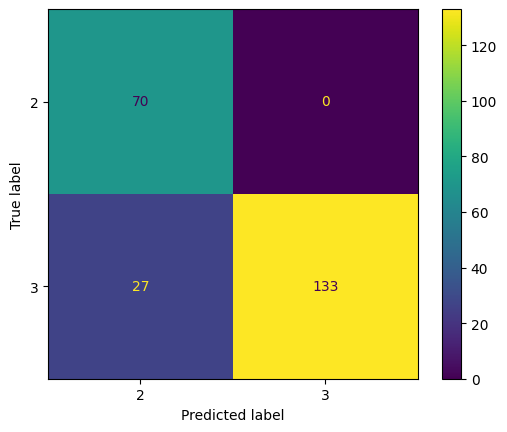

In [61]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_FIFS_shap_cMatrix, display_labels=MN_FIFS_shap_model.classes_)
disp.plot()
plt.show()